In [ ]:
%matplotlib inline

## Recurrent networks

Please also refer to the brilliant Tutorial [Learning Python by examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

Recurrent neural networks map a time series $\vec x_1, \ldots, \vec x_T \in \mathbb{R}^m$ to a _state sequence_ $\vec h_T \in \mathbb{R}^n$ and an _output sequence_ $\vec y_T \in \mathbb{R}^K$ by means of the following two, recursive equations:

\begin{align}
\vec h_t &= f(\vec x_t, \vec h_{t-1}) \\
\vec y_t &= g(\vec x_t, \vec h_t)
\end{align}
where $f$ and $g$ are both neural networks.

Recurrent networks are particularly challenging to train because $f$ influences itself over time via the state $\vec h$. Due to that recurrence, the state variable can easily blow up exponentially or decay exponentially. Similarly, gradients through this kind of network can explode or vanish (the exploding / vanishing gradient problem). A large amount of research has focused on how to deal with these problems, but we will only focus on one specific approach here which has been very successful in deep learning, namely _gating_.

The idea of gating is that the input does not influence the state in _every_ time step, but that a gate controlls when to incorporate input information into the memory/state and another gate controls whether to keep the old memory or reset it.
In this way, influence is propagated on well-defined time steps and learning becomes easier.

The original idea of gating is due to [Hochreiter and Schmidhuber (1997)](https://doi.org/10.1162/neco.1997.9.8.1735). Since then, models have been intensely refined and a review by [Greff et al. (2017)](https://arxiv.org/abs/1503.04069) has recently shown that many refinements perform similarly well. Therefore, we focus here on the simplest possible version of gated networks, so-called _gated recurrent units_ (GRUs, [Cho et al., 2014](https://arxiv.org/abs/1406.1078)).
The update equation for the state $\vec h_t$ is as follows:
\begin{equation}
\vec h_t = \vec z_t \odot \vec h_{t-1} + (1 - \vec z_t) \odot \mathrm{tanh}\Big(
U^h \cdot \vec x_t + W^h \cdot (\vec r_t \odot \vec h_{t-1}) + \vec b^h\Big)
\end{equation}
where $U^h$ is a $n \times m$ matrix which maps the current input vector to the state, where $W^h$ is a $n \times n$ matrix which maps the last state to the current state, where $\vec b^h$ is a constant or bias for the state computation, and $\odot$ denotes the element-wise multiplication. $\vec z_t$ is the first gate which controls how much we leave the state as it is and is also computed via a neural network layer:
\begin{equation}
\vec z_t = \sigma\Big(U^z \cdot \vec x_t + W^z \cdot \vec h_{t-1} + \vec b^z\Big)
\end{equation}
where $U^z$ is the input-to-gate weight matrix, where $W^z$ is the state-to-gate weight matrix, where $\vec b^z$ is the gate bias, and where $\sigma$ is the logistic function which ensures that all gate dimensions are in the range $[0, 1]$. $\vec r_t$ is the second gate which controls how much the past state influences the computation of the new state. It is also computed via a neural network layer of the same form.
\begin{equation}
\vec r_t = \sigma\Big(U^r \cdot \vec x_t + W^r \cdot \vec h_{t-1} + \vec b^r\Big)
\end{equation}
where $U^r$ is the input-to-gate weight matrix, where $W^r$ is the state-to-gate weight matrix, and where $\vec b^r$ is the gate bias.

For our example, we will assume that the output function $g$ is a linear layer
\begin{equation}
\vec y_t = g(\vec x_t, \vec h_t) = V \cdot \vec h_t + \vec b
\end{equation}
where $V$ is the state-to-output weight matrix and $\vec b$ is the output bias vector.

## Sine-Cosine Example

In a first example, our aim is to predict the current value of the sine function from the value of a cosine function. In other words, we have one-dimensional input and output spaces ($m = k = 1$) with $x_t = \cos(\frac{2 \pi}{\tau} t)$ and $y_t = \sin(\frac{2\pi}{\tau} t)$ where $\tau \in \mathbb{R}^+$ is the wavelength.

The ground truth for the predictive formula is a simple delay relationship, i.e.:

\begin{equation}
y_t = \sin\Big(\frac{2\pi}{\tau} t\Big) = \cos\Big(\frac{2 \pi}{\tau} t - \frac{\pi}{2}\Big) = \cos\Big(\frac{2 \pi}{\tau} \big[t - \frac{\tau}{4}\big]\Big) = x_{t - \frac{\tau}{4}}
\end{equation}

The simplest model to solve this task would thus be to just remember the last $\tau / 4 + 1$ cosine values and use them as output. However, that would require a state dimensionality of $n > \tau / 4$, which is fairly large. A nonlinear GRU can work with much less memory, as we will see.

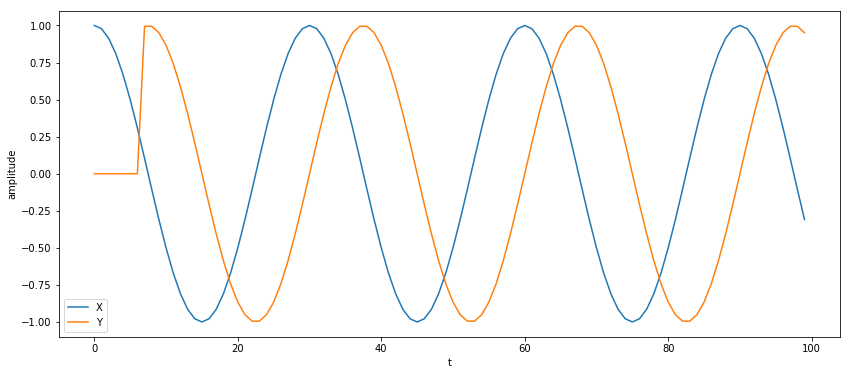

In [2]:
# For this exercise, we already provide data generation function (an 'oracle')
# which we can use
from recurrent_oracle import generate_sine_cosine

# So let us generate one example time series and plot it.
# If you execute this cell multiple times you see that
# the generated data have different wave lengths tau.
(X, Y, times) = generate_sine_cosine()

try:
    import seaborn as sns
    sns.set()
except:
    pass

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(list(times), list(X), list(times), list(Y))
plt.xlabel('t')
plt.ylabel('amplitude')
plt.legend(['X', 'Y'])
plt.show()


In [3]:
# To learn a recurrent neural network which can predict Y from X
# we need three ingredients:

# 1. We need a model, which in our case will be a GRU.

# Note that we use a sligthly customized version of the pytorch
# GRU here which is a bit easier to use. You are invited to
# inspect the source code in the SimpleGRU.py file in order to
# understand the interface in more detail.
# At any rate, we can initialize a SimpleGRU model by
# specifying the input dimension m, the state dimension n,
# and the output dimension k.
# In this case we have m = 1, k = 1, and n we can choose
# freely, e.g. n = 8
m = 1
n = 8
k = 1

import torch
import SimpleGRU
model = SimpleGRU.SimpleGRU(m, n, k)

# 2. We need a loss function which tells us how far our model is
# from the correct answer for the current example. For this
# purpose we use the mean square loss which is available in
# pytorch.
loss_function = torch.nn.MSELoss()

# 3. We need an optimizer that tells us how to adjust the parameters
# of the model given the gradient of the loss function. For that
# purpose, we use Adam with a relatively high learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [4]:
# Starting from these three ingredients we can optimize until
# the loss is low enough. You can also set the threshold lower
# to get even better results (if you have more time)
loss_threshold = 1E-2
learning_curve = []

while(not learning_curve or learning_curve[-1] > loss_threshold):
    # generate an example time series
    (X, Y, times) = generate_sine_cosine()
    # apply the model with the current parameters
    Y_predicted = model(X)
    # compute the loss and store it; note that the loss is an object
    # which we will also need to compute the gradient
    loss_object = loss_function(Y, Y_predicted)
    learning_curve.append(loss_object.item())

    # print the loss every 50 steps so that we see the progress
    # while learning happens
    if(len(learning_curve) % 50 == 0):
        print('loss after {} steps: {}'.format(len(learning_curve), learning_curve[-1]))

    # A special feature of PyTorch is that we need to zero the gradients
    # in the optimizer to ensure that past computations do
    # not influence the present ones
    optimizer.zero_grad()

    # compute the gradient of the loss
    loss_object.backward()

    # compute a step of the optimizer based on the gradient
    optimizer.step()


loss after 50 steps: 0.09161659330129623
loss after 100 steps: 0.03586816415190697
loss after 150 steps: 0.021564561873674393
loss after 200 steps: 0.03252416476607323
loss after 250 steps: 0.03511497378349304
loss after 300 steps: 0.016129465773701668
loss after 350 steps: 0.024919450283050537
loss after 400 steps: 0.07658589631319046


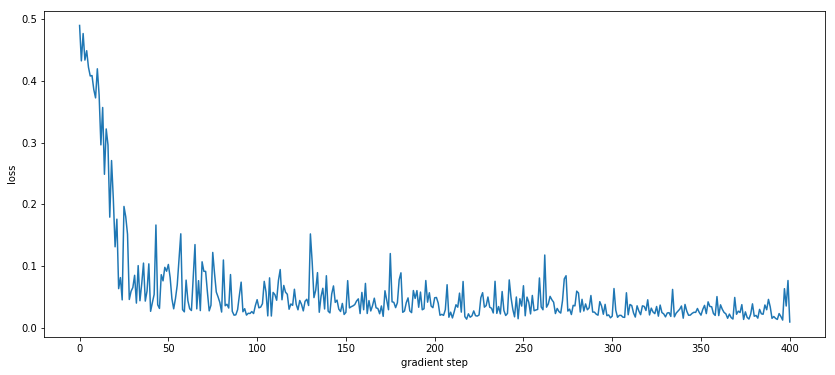

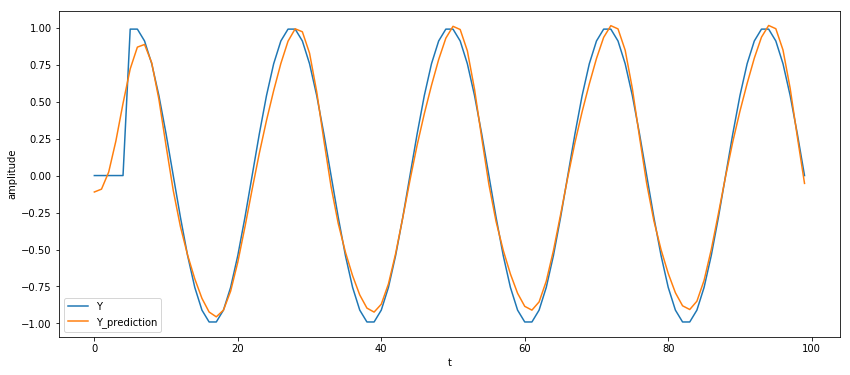

In [5]:
# plot the learning curve

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(list(range(len(learning_curve))), learning_curve)
plt.xlabel('gradient step')
plt.ylabel('loss')
plt.show()

# plot the actual signal and the predicted signal for the last
# generated training data point
plt.figure(figsize=(14, 6))
plt.plot(list(times), list(Y), list(times), list(Y_predicted))
plt.xlabel('t')
plt.ylabel('amplitude')
plt.legend(['Y', 'Y_prediction'])
plt.show()

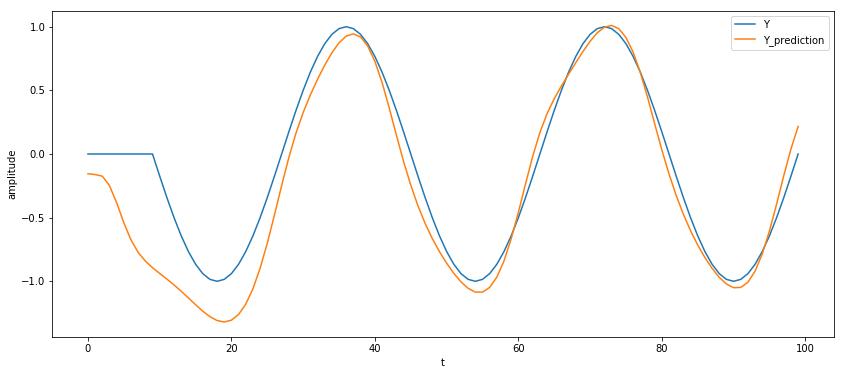

In [6]:
# to really test how well the network performs its task,
# we can also try some wave that was never part of the
# training data, namely by phaseshifting the input and
# output wave by another quarter wavelength

(X, Y, times) = generate_sine_cosine(phaseshift=0.25)
# apply the model
Y_predicted = model(X)
# plot the actual signal and the predicted signal for the last
# generated training data point

plt.figure(figsize=(14, 6))
plt.plot(list(times), list(Y), list(times), list(Y_predicted))
plt.xlabel('t')
plt.ylabel('amplitude')
plt.legend(['Y', 'Y_prediction'])
plt.show()